In [1]:
#pip install albumentationsx

In [2]:
#pip install pytorch-lightning

In [3]:
pip install torchmetrics

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python3.12 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from training_action_recognition import ActionRecognition

In [5]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

print(f"Using {device}")

Using cuda:1


1. Get datasets

In [6]:
from charades_fileparser import charadesClassParser
from charades_dataset import CharadesDataset
from torch.utils.data import DataLoader, random_split

In [7]:
classes_file = "LT2326_charades/classes/actionclass_description.txt"
object_classes_file = "LT2326_charades/classes/objectclass_description.txt"
verb_classes_file = "LT2326_charades/classes/verbclass_description.txt"
mapping_file = "LT2326_charades/classes/mapping-action_object_verb.txt"
train_annotations = "LT2326_charades/annotations/Charades_train_annotations.csv"
test_annotations = "LT2326_charades/annotations/Charades_test_annotations.csv"
video_dir = "LT2326_charades/charades_video_files"

In [8]:
print("Testing class parser...")
class_parser = charadesClassParser(classes_file=classes_file,
                                   object_classes_file=object_classes_file,
                                   verb_classes_file=verb_classes_file,
                                   mapping_file=mapping_file
                                  )

Testing class parser...


In [9]:
print("Creating dataset...")
train_dataset = CharadesDataset(
    annotations_file=train_annotations,
    video_dir=video_dir,
    classes_file=classes_file,
    object_classes_file=object_classes_file,
    verb_classes_file=verb_classes_file,
    mapping_file=mapping_file,
    num_frames=32,
    image_size=224,
    is_training=True
)

test_dataset = CharadesDataset(
    annotations_file=test_annotations,
    video_dir=video_dir,
    classes_file=classes_file,
    object_classes_file=object_classes_file,
    verb_classes_file=verb_classes_file,
    mapping_file=mapping_file,
    num_frames=32,
    image_size=224,
    is_training=False
)             

Creating dataset...
Loaded 33 verbs
Loaded 38 objects
Loaded 157 actions
Loaded 157 action mappings

Example mappings:
c000: Holding some clothes
Verb: v008 (hold)
Object: o009 (clothes)
c001: Putting clothes somewhere
Verb: v016 (put)
Object: o009 (clothes)
c002: Taking some clothes from somewhere
Verb: v023 (take)
Object: o009 (clothes)
c003: Throwing clothes somewhere
Verb: v025 (throw)
Object: o009 (clothes)
c004: Tidying some clothes
Verb: v026 (tidy)
Object: o009 (clothes)
Loaded 33 verbs
Loaded 38 objects
Loaded 157 actions
Loaded 157 action mappings

Example mappings:
c000: Holding some clothes
Verb: v008 (hold)
Object: o009 (clothes)
c001: Putting clothes somewhere
Verb: v016 (put)
Object: o009 (clothes)
c002: Taking some clothes from somewhere
Verb: v023 (take)
Object: o009 (clothes)
c003: Throwing clothes somewhere
Verb: v025 (throw)
Object: o009 (clothes)
c004: Tidying some clothes
Verb: v026 (tidy)
Object: o009 (clothes)


In [10]:
# Split test into val and test
generator = torch.Generator().manual_seed(34)
val_dataset, test_dataset = random_split(test_dataset, [0.5, 0.5], generator=generator)

In [11]:
#create dataloaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=4, pin_memory=True)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Training samples: 7985
Validation samples: 932
Test samples: 931


In [12]:
# Get dataset info
num_verbs = train_dataset.get_num_verbs()
num_objects = train_dataset.get_num_objects()
num_actions = train_dataset.get_num_actions()

print(f"Number of verbs: {num_verbs}")
print(f"Number of objects: {num_objects}")
print(f"Number of actions: {num_actions}")

Number of verbs: 33
Number of objects: 38
Number of actions: 157


EXPERIMENT 1: SlowFast from scratch

In [13]:
from MultiHeadSlowFast_model import MultiHeadSlowFast

In [14]:
model_scratch = MultiHeadSlowFast(
    num_verbs=num_verbs,
    num_objects=num_objects,
    num_actions=num_actions
)

In [15]:
lightning_model_scratch = ActionRecognition(
    model=model_scratch,
    model_name="from_scratch",
    learning_rate=1e-3  # Higher LR for training from scratch
)

In [16]:
checkpoint_scratch = ModelCheckpoint(
    monitor='from_scratch/val_total_loss',
    dirpath='checkpoints_from_scratch',
    filename='scratch-{epoch:02d}-{val_total_loss:.2f}',
    save_top_k=1,
    mode='min'
)

early_stop_scratch = EarlyStopping(
    monitor='from_scratch/val_total_loss',
    patience=10,
    mode='min',
    verbose=True
)

In [17]:
#train
trainer_scratch = pl.Trainer(
    max_epochs=50,
    callbacks=[checkpoint_scratch, early_stop_scratch],
    accelerator='gpu',
    devices=[1],
    log_every_n_steps=10,
    precision='16-mixed',
    gradient_clip_val=1.0
)

trainer_scratch.fit(lightning_model_scratch, train_loader, val_loader)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025-11-24 19:07:25.737248: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/gusmardham@GU.GU.SE/.local/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:751: Checkpoint directory /home/gusmardham@GU.GU.SE/checkpoints_from_scratch exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/usr/local/lib64/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/home/gusmardham@GU.GU.SE/.local/lib/python3.12/site-packages/pytorch_lig

Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/gusmardham@GU.GU.SE/.local/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 8. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

/home/gusmardham@GU.GU.SE/.local/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 4. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
Metric from_scratch/val_total_loss improved. New best score: 0.954


Validation: |                                             | 0/? [00:00<?, ?it/s]

Metric from_scratch/val_total_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.951


Validation: |                                             | 0/? [00:00<?, ?it/s]

Metric from_scratch/val_total_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.938


Validation: |                                             | 0/? [00:00<?, ?it/s]

Metric from_scratch/val_total_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.930


Validation: |                                             | 0/? [00:00<?, ?it/s]

Metric from_scratch/val_total_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.927


Validation: |                                             | 0/? [00:00<?, ?it/s]

Metric from_scratch/val_total_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.915


Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Metric from_scratch/val_total_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.911


Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Monitored metric from_scratch/val_total_loss did not improve in the last 10 records. Best score: 0.911. Signaling Trainer to stop.


In [18]:
# Test
print("\\nTesting from-scratch model...")
test_results_scratch = trainer_scratch.test(
    lightning_model_scratch, 
    test_loader,
    ckpt_path=checkpoint_scratch.best_model_path
)

print(f"\\nFrom-scratch training complete!")
print(f"Best checkpoint: {checkpoint_scratch.best_model_path}")

Restoring states from the checkpoint path at /home/gusmardham@GU.GU.SE/checkpoints_from_scratch/scratch-epoch=09-val_total_loss=0.00.ckpt


\nTesting from-scratch model...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
Loaded model weights from the checkpoint at /home/gusmardham@GU.GU.SE/checkpoints_from_scratch/scratch-epoch=09-val_total_loss=0.00.ckpt


Testing: |                                                | 0/? [00:00<?, ?it/s]

/home/gusmardham@GU.GU.SE/.local/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 3. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃               Test metric                ┃               DataLoader 0               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       from_scratch/test_action_acc       │            0.9435168504714966            │
│    from_scratch/test_action_f1_macro     │                   0.0                    │
│    from_scratch/test_action_f1_micro     │                   0.0                    │
│  from_scratch/test_action_hamming_loss   │           0.05648333951830864            │
│      from_scratch/test_action_loss       │           0.20023512840270996            │
│       from_scratch/test_action_mAP       │           0.07681697607040405            │
│ from_scratch/test_action_precision_macro │                   0.0                    │
│  from_scratch/test_action_recall_macro   │                   0.0                    │
│       from_scratch/test_object_acc       │            0.873452365398407             │
│    from_scratch/test_object_f1_macro     │           0.014890885911881924           │
│    from_scratch/test_object_f1_micro     │           0.11469250172376633            │
│  from_scratch/test_object_hamming_loss   │           0.12654757499694824            │
│      from_scratch/test_object_loss       │            0.3474191129207611            │
│       from_scratch/test_object_mAP       │           0.16616231203079224            │
│ from_scratch/test_object_precision_macro │           0.014619884081184864           │
│  from_scratch/test_object_recall_macro   │           0.015172125771641731           │
│      from_scratch/test_overall_mAP       │           0.15542972087860107            │
│       from_scratch/test_total_loss       │            0.9171504378318787            │
│        from_scratch/test_verb_acc        │            0.8427889943122864            │
│     from_scratch/test_verb_f1_macro      │           0.044352151453495026           │
│     from_scratch/test_verb_f1_micro      │           0.29489052295684814            │
│   from_scratch/test_verb_hamming_loss    │           0.15721121430397034            │
│       from_scratch/test_verb_loss        │            0.3694959878921509            │
│        from_scratch/test_verb_mAP        │           0.22330988943576813            │
│  from_scratch/test_verb_precision_macro  │           0.07320249080657959            │
│   from_scratch/test_verb_recall_macro    │           0.04569067806005478            │
└──────────────────────────────────────────┴──────────────────────────────────────────┘

\nFrom-scratch training complete!
Best checkpoint: /home/gusmardham@GU.GU.SE/checkpoints_from_scratch/scratch-epoch=09-val_total_loss=0.00.ckpt


EXPERIMENT 2: Pre-trained model as backbone

phase 1 of experiment 2: frozen backbone

In [19]:
from pretrainedSlowFast_model import MultiHeadSlowFastPretrained

In [20]:
model_pretrained_frozen = MultiHeadSlowFastPretrained(
    num_verbs=num_verbs,
    num_objects=num_objects,
    num_actions=num_actions,
    freeze_backbone=True
)

Using cache found in /home/gusmardham@GU.GU.SE/.cache/torch/hub/facebookresearch_pytorchvideo_main


In [21]:
lightning_pretrained_frozen = ActionRecognition(
    model=model_pretrained_frozen,
    model_name="pretrained_frozen",
    learning_rate=1e-3 #higher for training only heads
)

In [22]:
checkpoint_frozen = ModelCheckpoint(
    monitor='pretrained_frozen/val_total_loss',
    dirpath='checkpoints_pretrained',
    filename='frozen-{epoch:02d}-{val_total_loss:.2f}',
    save_top_k=1,
    mode='min'
)

In [23]:
trainer_frozen = pl.Trainer(
    max_epochs=10,
    callbacks=[checkpoint_frozen],
    accelerator='gpu',
    devices=[1],
    log_every_n_steps=10,
    precision='16-mixed'
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [24]:
print("\\nStarting frozen backbone training...")
trainer_frozen.fit(lightning_pretrained_frozen, train_loader, val_loader)

\nStarting frozen backbone training...


/home/gusmardham@GU.GU.SE/.local/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:751: Checkpoint directory /home/gusmardham@GU.GU.SE/checkpoints_pretrained exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

   | Name                  | Type                        | Params | Mode 
-------------------------------------------------------------------------------
0  | model                 | MultiHeadSlowFastPretrained | 34.9 M | train
1  | criterion             | BCEWithLogitsLoss           | 0      | train
2  | test_verb_map         | MultilabelAveragePrecision  | 0      | train
3  | test_object_map       | MultilabelAveragePrecision  | 0      | train
4  | test_action_map       | MultilabelAveragePrecision  | 0      | train
5  | test_verb_f1_macro    | MultilabelF1Score           | 0      | train
6  | test_object_f1_macro  | MultilabelF1Score           | 0      | train
7  | test_action_f1_macro  | MultilabelF1Score           | 0      | t

Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [25]:
print(f"\\nFrozen phase complete!")
print(f"Best checkpoint: {checkpoint_frozen.best_model_path}")

\nFrozen phase complete!
Best checkpoint: /home/gusmardham@GU.GU.SE/checkpoints_pretrained/frozen-epoch=03-val_total_loss=0.00.ckpt


phase 2 of experiment 2: fine-tune pre-trained model using Charades

In [26]:
model_pretrained_finetune = MultiHeadSlowFastPretrained(
    num_verbs=num_verbs,
    num_objects=num_objects,
    num_actions=num_actions,
    freeze_backbone=False
)

Using cache found in /home/gusmardham@GU.GU.SE/.cache/torch/hub/facebookresearch_pytorchvideo_main


In [27]:
# Load the frozen phase weights
checkpoint_dict = torch.load(checkpoint_frozen.best_model_path, weights_only=True)
model_state = checkpoint_dict['state_dict']
model_pretrained_finetune.load_state_dict(model_state, strict=False)

_IncompatibleKeys(missing_keys=['backbone.slowfast.blocks.0.multipathway_blocks.0.conv.weight', 'backbone.slowfast.blocks.0.multipathway_blocks.0.norm.weight', 'backbone.slowfast.blocks.0.multipathway_blocks.0.norm.bias', 'backbone.slowfast.blocks.0.multipathway_blocks.0.norm.running_mean', 'backbone.slowfast.blocks.0.multipathway_blocks.0.norm.running_var', 'backbone.slowfast.blocks.0.multipathway_blocks.1.conv.weight', 'backbone.slowfast.blocks.0.multipathway_blocks.1.norm.weight', 'backbone.slowfast.blocks.0.multipathway_blocks.1.norm.bias', 'backbone.slowfast.blocks.0.multipathway_blocks.1.norm.running_mean', 'backbone.slowfast.blocks.0.multipathway_blocks.1.norm.running_var', 'backbone.slowfast.blocks.0.multipathway_fusion.conv_fast_to_slow.weight', 'backbone.slowfast.blocks.0.multipathway_fusion.norm.weight', 'backbone.slowfast.blocks.0.multipathway_fusion.norm.bias', 'backbone.slowfast.blocks.0.multipathway_fusion.norm.running_mean', 'backbone.slowfast.blocks.0.multipathway_fusi

In [28]:
lightning_model_finetune = ActionRecognition(
    model=model_pretrained_finetune,
    model_name="pretrained_finetune",
    learning_rate=1e-4  # Lower LR for fine-tuning
)

In [29]:
checkpoint_finetune = ModelCheckpoint(
    monitor='pretrained_finetune/val_total_loss',
    dirpath='checkpoints_pretrained',
    filename='finetune-{epoch:02d}-{val_total_loss:.2f}',
    save_top_k=1,
    mode='min'
)

early_stop_finetune = EarlyStopping(
    monitor='pretrained_finetune/val_total_loss',
    patience=7,
    mode='min'
)

In [30]:
trainer_finetune = pl.Trainer(
    max_epochs=30,
    callbacks=[checkpoint_finetune, early_stop_finetune],
    accelerator='gpu',
    devices=[1],
    log_every_n_steps=10,
    precision='16-mixed',
    gradient_clip_val=1.0
)

trainer_finetune.fit(lightning_model_finetune, train_loader, val_loader)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

   | Name                  | Type                        | Params | Mode 
-------------------------------------------------------------------------------
0  | model                 | MultiHeadSlowFastPretrained | 34.9 M | train
1  | criterion             | BCEWithLogitsLoss           | 0      | train
2  | test_verb_map         | MultilabelAveragePrecision  | 0      | train
3  | test_object_map       | MultilabelAveragePrecision  | 0      | train
4  | test_action_map       | MultilabelAveragePrecision  | 0      | train
5  | test_verb_f1_macro    | MultilabelF1Score           | 0      | train
6  | test_object_f1_macro  | MultilabelF1Score           | 0      | train
7  | test_action_f1_macro  | MultilabelF1Score           | 0      | train
8  | test_verb_f1_micro    | MultilabelF1Scor

Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

In [31]:
# Test
print("\\nTesting pre-trained model...")
test_results_pretrained = trainer_finetune.test(
    lightning_model_finetune,
    test_loader,
    ckpt_path=checkpoint_finetune.best_model_path
)

Restoring states from the checkpoint path at /home/gusmardham@GU.GU.SE/checkpoints_pretrained/finetune-epoch=01-val_total_loss=0.00.ckpt


\nTesting pre-trained model...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
Loaded model weights from the checkpoint at /home/gusmardham@GU.GU.SE/checkpoints_pretrained/finetune-epoch=01-val_total_loss=0.00.ckpt


Testing: |                                                | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                   Test metric                   ┃                  DataLoader 0                   ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       pretrained_finetune/test_action_acc       │               0.9443919658660889                │
│    pretrained_finetune/test_action_f1_macro     │               0.04869343340396881               │
│    pretrained_finetune/test_action_f1_micro     │               0.10445129871368408               │
│  pretrained_finetune/test_action_hamming_loss   │               0.0556076243519783                │
│      pretrained_finetune/test_action_loss       │               0.18395018577575684               │
│       pretrained_finetune/test_action_mAP       │               0.17685124278068542               │
│ pretrained_finetune/test_action_precision_macro │               0.16913793981075287               │
│  pretrained_finetune/test_action_recall_macro   │               0.03338213264942169               │
│       pretrained_finetune/test_object_acc       │               0.8782863020896912                │
│    pretrained_finetune/test_object_f1_macro     │               0.1550375521183014                │
│    pretrained_finetune/test_object_f1_micro     │               0.2837657928466797                │
│  pretrained_finetune/test_object_hamming_loss   │               0.12171406298875809               │
│      pretrained_finetune/test_object_loss       │               0.32036522030830383               │
│       pretrained_finetune/test_object_mAP       │               0.31812041997909546               │
│ pretrained_finetune/test_object_precision_macro │               0.37764859199523926               │
│  pretrained_finetune/test_object_recall_macro   │               0.11507511883974075               │
│      pretrained_finetune/test_overall_mAP       │               0.29337430000305176               │
│       pretrained_finetune/test_total_loss       │               0.8358904719352722                │
│        pretrained_finetune/test_verb_acc        │               0.8654752373695374                │
│     pretrained_finetune/test_verb_f1_macro      │               0.22840984165668488               │
│     pretrained_finetune/test_verb_f1_micro      │               0.5076831579208374                │
│   pretrained_finetune/test_verb_hamming_loss    │               0.1345246285200119                │
│       pretrained_finetune/test_verb_loss        │               0.33157503604888916               │
│        pretrained_finetune/test_verb_mAP        │                0.385151207447052                │
│  pretrained_finetune/test_verb_precision_macro  │               0.48595479130744934               │
│   pretrained_finetune/test_verb_recall_macro    │               0.1850813925266266                │
└─────────────────────────────────────────────────┴─────────────────────────────────────────────────┘

In [32]:
print(f"\\nPre-trained training complete!")
print(f"Best checkpoint: {checkpoint_finetune.best_model_path}")

\nPre-trained training complete!
Best checkpoint: /home/gusmardham@GU.GU.SE/checkpoints_pretrained/finetune-epoch=01-val_total_loss=0.00.ckpt


In [33]:
import pickle

# Save results
with open('test_results_scratch.pkl', 'wb') as f:
    pickle.dump(test_results_scratch, f)
    
with open('test_results_pretrained.pkl', 'wb') as f:
    pickle.dump(test_results_pretrained, f)

print("Results saved!")

Results saved!


COMPARISON: model from scratch vs pre-trained model

In [44]:

import importlib
import charades_comparison
importlib.reload(charades_comparison)
from charades_comparison import ModelComparison

In [45]:
import pickle

# Load results
with open('test_results_scratch.pkl', 'rb') as f:
    test_results_scratch = pickle.load(f)
    
with open('test_results_pretrained.pkl', 'rb') as f:
    test_results_pretrained = pickle.load(f)

In [46]:
# Check what's actually in the files
with open('test_results_scratch.pkl', 'rb') as f:
    test_results_scratch = pickle.load(f)
    print("Scratch results:", test_results_scratch)
    
with open('test_results_pretrained.pkl', 'rb') as f:
    test_results_pretrained = pickle.load(f)
    print("Pretrained results:", test_results_pretrained)

Scratch results: [{'from_scratch/test_total_loss': 0.9171504378318787, 'from_scratch/test_verb_loss': 0.3694959878921509, 'from_scratch/test_object_loss': 0.3474191129207611, 'from_scratch/test_action_loss': 0.20023512840270996, 'from_scratch/test_verb_acc': 0.8427889943122864, 'from_scratch/test_object_acc': 0.873452365398407, 'from_scratch/test_action_acc': 0.9435168504714966, 'from_scratch/test_verb_mAP': 0.22330988943576813, 'from_scratch/test_object_mAP': 0.16616231203079224, 'from_scratch/test_action_mAP': 0.07681697607040405, 'from_scratch/test_overall_mAP': 0.15542972087860107, 'from_scratch/test_verb_f1_macro': 0.044352151453495026, 'from_scratch/test_object_f1_macro': 0.014890885911881924, 'from_scratch/test_action_f1_macro': 0.0, 'from_scratch/test_verb_f1_micro': 0.29489052295684814, 'from_scratch/test_object_f1_micro': 0.11469250172376633, 'from_scratch/test_action_f1_micro': 0.0, 'from_scratch/test_verb_precision_macro': 0.07320249080657959, 'from_scratch/test_object_prec

In [47]:
comparison = ModelComparison()

In [48]:
#add results from 'from scratch' model
comparison.add_model_results("from_scratch" , test_results_scratch)

In [49]:
#add results from 'pretrained' model
comparison.add_model_results("pretrained_finetune", test_results_pretrained)

In [50]:
print("From scratch keys:", test_results_scratch.keys() if isinstance(test_results_scratch, dict) else test_results_scratch[0].keys())
print("\nPretrained keys:", test_results_pretrained.keys() if isinstance(test_results_pretrained, dict) else test_results_pretrained[0].keys())

From scratch keys: dict_keys(['from_scratch/test_total_loss', 'from_scratch/test_verb_loss', 'from_scratch/test_object_loss', 'from_scratch/test_action_loss', 'from_scratch/test_verb_acc', 'from_scratch/test_object_acc', 'from_scratch/test_action_acc', 'from_scratch/test_verb_mAP', 'from_scratch/test_object_mAP', 'from_scratch/test_action_mAP', 'from_scratch/test_overall_mAP', 'from_scratch/test_verb_f1_macro', 'from_scratch/test_object_f1_macro', 'from_scratch/test_action_f1_macro', 'from_scratch/test_verb_f1_micro', 'from_scratch/test_object_f1_micro', 'from_scratch/test_action_f1_micro', 'from_scratch/test_verb_precision_macro', 'from_scratch/test_object_precision_macro', 'from_scratch/test_action_precision_macro', 'from_scratch/test_verb_recall_macro', 'from_scratch/test_object_recall_macro', 'from_scratch/test_action_recall_macro', 'from_scratch/test_verb_hamming_loss', 'from_scratch/test_object_hamming_loss', 'from_scratch/test_action_hamming_loss'])

Pretrained keys: dict_keys([

In [51]:
df = comparison.print_comparison_table()


MODEL COMPARISON - SORTED BY OVERALL mAP

 mAP SCORES (Primary Charades Metric):
--------------------------------------------------------------------------------
              Model  Overall mAP  Verb mAP  Object mAP  Action mAP
pretrained_finetune     0.293374  0.385151    0.318120    0.176851
       from_scratch     0.155430  0.223310    0.166162    0.076817

 F1 SCORES (Macro Average):
--------------------------------------------------------------------------------
              Model  Verb F1 (macro)  Object F1 (macro)  Action F1 (macro)
pretrained_finetune         0.228410           0.155038           0.048693
       from_scratch         0.044352           0.014891           0.000000

 F1 SCORES (Micro Average (weighted by class frequency):
--------------------------------------------------------------------------------
              Model  Verb F1 (micro)  Object F1 (micro)  Action F1 (micro)
pretrained_finetune         0.507683           0.283766           0.104451
       from_


 Comparison plot saved to: model_comparison.png


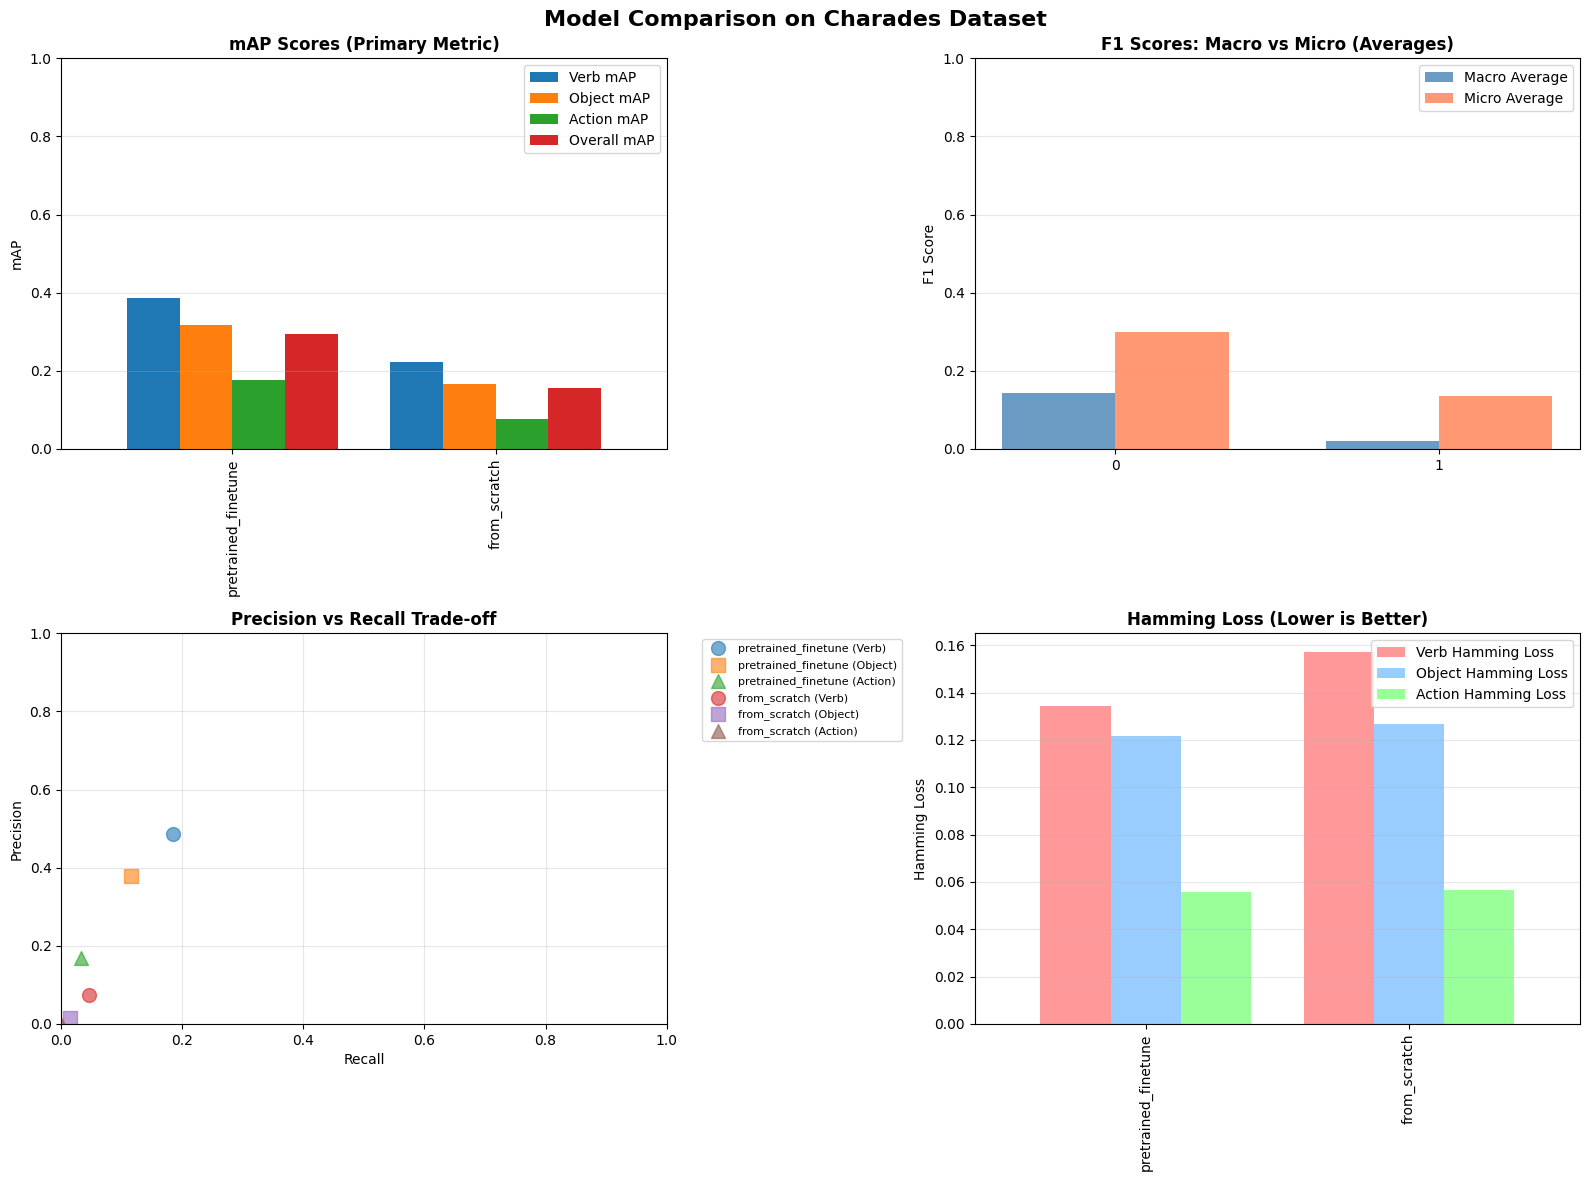

In [52]:
comparison.plot_comparison()

In [53]:
# Save results
comparison.save_results()
comparison.export_to_csv()


 Results saved to: model_comparison_results.json

 CSV exported to: model_comparison.csv
